## Construção do Modelo Preditivo

Após realizar uma análise exploratória detalhada dos dados, identificamos padrões e insights que orientarão a construção do modelo preditivo. 

Nesta etapa, focaremos em:
1. Preparar os dados para modelagem, garantindo que todas as variáveis estejam no formato adequado.
2. Escolher um algoritmo de aprendizado de máquina adequado para a previsão, considerando a natureza dos dados.
3. Avaliar o desempenho do modelo utilizando métricas apropriadas, como RMSE, MAE ou R².


### Importando bibliotecas

In [99]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
import joblib

### Lendo os dados

In [100]:
dataset = pd.read_csv("../data/model_inputs/ml_inputs.csv", sep=";", decimal=",")

In [101]:
dataset.columns

Index(['VL_RECEITA_BRUTA', 'QT_DEVOLUCAO', 'VL_RECEITA_LIQUIDA', 'VL_PRECO',
       'QT_VENDA_BRUTO'],
      dtype='object')

### Testando droppar uma coluna para evitar multicolinearidade e overfitting

In [102]:
dataset.drop(columns="VL_RECEITA_LIQUIDA", inplace=True)

In [103]:
target = "QT_VENDA_BRUTO"
X = dataset.drop(columns=target)
y = dataset[target]

In [104]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [105]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")

joblib.dump(model, "../models/model.pkl")

MSE: 6392569.902453322
MAE: 210.58595616300673
R2: 0.9935662591794348


['../models/model.pkl']

### Testando cross-validation para avaliar a performance do modelo em diferentes folds com o objetivo de verificar a consistência nas predições

In [106]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
import numpy as np

# Initialize the model
model = RandomForestRegressor(random_state=42)

# Perform cross-validation
cv_results = cross_validate(
    model,
    X_train,  # Use raw data, no need for scaling
    y_train,
    cv=5,
    scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
)

# Print the cross-validation results
print(f"Cross-Validation R2 Scores: {cv_results['test_r2']}")
print(f"Cross-Validation MSE Scores: {-cv_results['test_neg_mean_squared_error']}")
print(f"Cross-Validation MAE Scores: {-cv_results['test_neg_mean_absolute_error']}")

# Compute mean scores
print(f"Mean R2: {np.mean(cv_results['test_r2'])}")
print(f"Mean MSE: {np.mean(-cv_results['test_neg_mean_squared_error'])}")
print(f"Mean MAE: {np.mean(-cv_results['test_neg_mean_absolute_error'])}")

Cross-Validation R2 Scores: [0.98886307 0.98373678 0.99256964 0.99012215 0.98759512]
Cross-Validation MSE Scores: [12336173.40502782 18119177.68206285  8391957.36821591 13221603.6872585
 12262587.53383486]
Cross-Validation MAE Scores: [248.20412524 234.38299935 234.10726146 253.74670642 249.50879061]
Mean R2: 0.9885773514630921
Mean MSE: 12866299.93527999
Mean MAE: 243.98997661546224


### Verifica-se previsões bem alinhadas, o que pode indicar overfitting

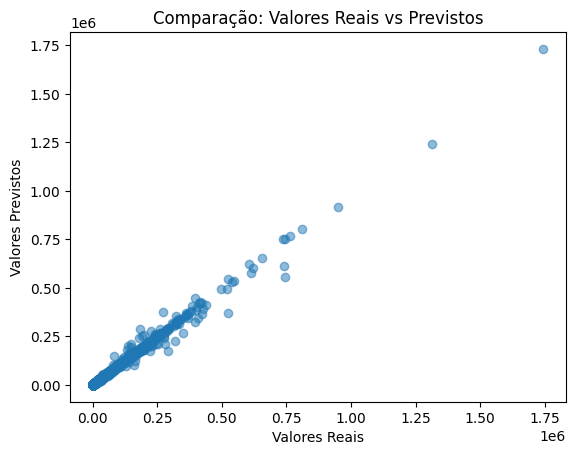

In [107]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Valores Reais")
plt.ylabel("Valores Previstos")
plt.title("Comparação: Valores Reais vs Previstos")
plt.show()

### Uma alta correlação entre as variáveis e o target pode indicar/explicar as métricas atingidas anteriormente.
- Verificou-se as importâncias de features e se não ouve data leakeage durante o processo
- Desde o começo da análise exploratória foi possível averiguar a grande correlação entre estas variáveis, o que se destacou também ao treinar o modelo inicial.

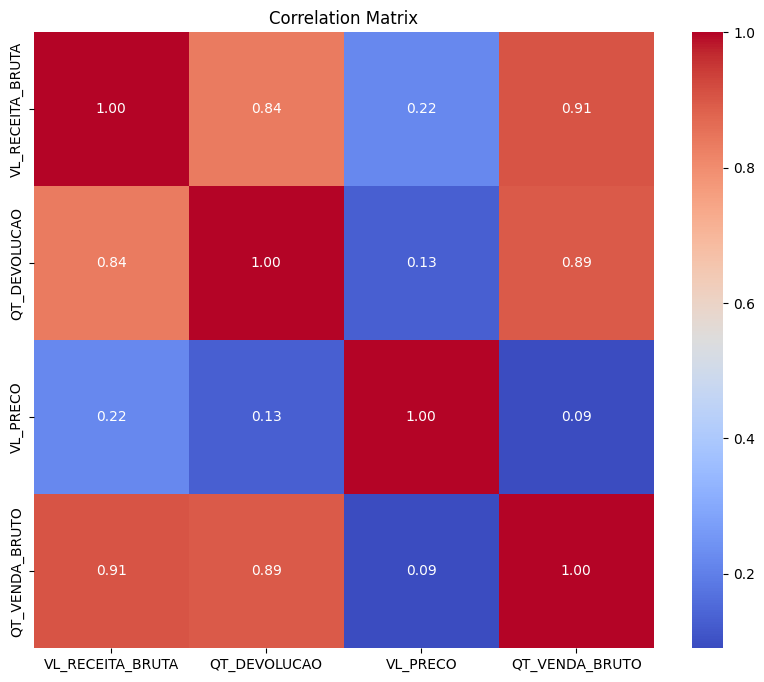

In [108]:
import seaborn as sns

import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = dataset.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### Agora, separaremos os produtos principais e treinar um modelo para eles, assim diminuindo o escopo e avaliando os resultados de uma abordagem mais direcionada

In [109]:
dataset.QT_VENDA_BRUTO

0         11934.0
1           540.0
2         54012.0
3           438.0
4          2760.0
           ...   
173918     4266.0
173919     7224.0
173920      360.0
173921      384.0
173922      888.0
Name: QT_VENDA_BRUTO, Length: 173923, dtype: float64

In [110]:
processed_data = pd.read_csv("../data/processed/dataset.csv", sep=";", decimal=",")

In [111]:
sales_per_product = processed_data.groupby("COD_MATERIAL")["QT_VENDA_BRUTO"].sum()

In [112]:
most_sold_products = sales_per_product.sort_values(ascending=False).head(5)
most_sold_products

COD_MATERIAL
177396    5.177174e+07
69198     3.468620e+07
427350    3.308824e+07
441876    2.961724e+07
152982    2.615941e+07
Name: QT_VENDA_BRUTO, dtype: float64

In [113]:
top_products = processed_data[
    processed_data["COD_MATERIAL"].isin(most_sold_products.index)
]

In [114]:
dataset.columns

Index(['VL_RECEITA_BRUTA', 'QT_DEVOLUCAO', 'VL_PRECO', 'QT_VENDA_BRUTO'], dtype='object')

In [115]:
top_products[dataset.columns]

,VL_RECEITA_BRUTA,QT_DEVOLUCAO,VL_PRECO,QT_VENDA_BRUTO
447,17126833.26,3373.713503,1071.90,123018.0000
472,11563555.80,1722.000000,1073.40,82896.0000
575,7152097.26,2693.668476,634.02,109708.7766
642,4563006.00,1530.000000,863.40,43734.0000
909,3141918.60,1860.000000,563.40,57468.0000
...,...,...,...,...
172809,4423902.60,870.000000,803.40,46848.0000
173009,9443476.20,1602.000000,683.40,126312.0000
173297,15531709.62,8122.569085,485.34,374520.0000
173316,7705888.20,2526.000000,563.40,140592.0000


In [117]:
for product in most_sold_products.index:
    product_data = top_products[top_products["COD_MATERIAL"] == product]
    product_data = product_data[dataset.columns]
    X_product = product_data.drop(columns="QT_VENDA_BRUTO")
    y_product = product_data["QT_VENDA_BRUTO"]

    X_train, X_test, y_train, y_test = train_test_split(
        X_product, y_product, test_size=0.2, random_state=42
    )

    rf_model_product = RandomForestRegressor(random_state=42)
    rf_model_product.fit(X_train, y_train)

    y_pred = rf_model_product.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Product: {product}")
    print(f"MSE: {mse}")
    print(f"MAE: {mae}")
    print(f"R2: {r2}")

Product: 177396
MSE: 2479240004.8347626
MAE: 17519.79488372093
R2: 0.9148937233261687
Product: 69198
MSE: 1912615945.814099
MAE: 14995.592245953494
R2: 0.9839841506032071
Product: 427350
MSE: 944411583.7601501
MAE: 12134.507937069771
R2: 0.9182130778176857
Product: 441876
MSE: 23566249981.52453
MAE: 44009.56695652174
R2: 0.8756089698284075
Product: 152982
MSE: 382680000.4576186
MAE: 10897.649302325583
R2: 0.975004556436435


## Desempenho do Modelo por Produto

O desempenho do modelo foi avaliado em diferentes produtos para verificar sua capacidade preditiva em subconjuntos específicos de dados. Abaixo estão os resultados para cada produto:

---

### **Métricas de Desempenho**

| **Produto** | **MSE**            | **MAE**        | **R²**       |
|-------------|--------------------|----------------|--------------|
| **177396**  | 2.479.240.004,83   | 17.519,79      | 0,9149       |
| **69198**   | 1.912.615.945,81   | 14.995,59      | 0,9839       |
| **427350**  | 944.411.583,76     | 12.134,51      | 0,9182       |
| **441876**  | 23.566.249.981,52  | 44.009,57      | 0,8756       |
| **152982**  | 382.680.000,46     | 10.897,65      | 0,9750       |

---

### **Principais Observações**
1. **Valores de R²:**
   - Os valores de R² indicam um forte poder preditivo para todos os produtos, variando de **0,87** a **0,98**.
   - Isso sugere que o modelo explica uma grande parte da variabilidade na demanda de cada produto.

2. **MSE (Erro Quadrático Médio):**
   - Os valores de MSE variam entre os produtos, refletindo diferenças na variabilidade da demanda.
   - Produtos como **441876**, com MSE mais elevado, podem apresentar maiores ou mais imprevisíveis flutuações na demanda.

3. **MAE (Erro Absoluto Médio):**
   - O MAE fornece uma visão intuitiva do erro médio nas previsões de cada produto.
   - Produtos como **152982** e **427350** apresentam MAE relativamente baixos, indicando previsões mais precisas.

---

### **Conclusão**
O modelo demonstra um forte desempenho em diferentes produtos, alcançando altos valores de R² e erros razoáveis. No entanto, produtos com MSE e MAE mais elevados, como **441876**, podem se beneficiar de uma análise mais detalhada ou abordagens de modelagem específicas para capturar padrões de demanda únicos.

---

### **Próximos Passos**
1. **Análise Adicional:**
   - Investigar produtos com MSE e MAE mais elevados para identificar possíveis problemas nos dados ou fatores únicos que influenciam a demanda.
2. **Aprimoramento do Modelo:**
   - Considerar ajustes no modelo ou desenvolver modelos específicos para produtos com padrões de demanda mais complexos.
3. **Importância das Features:**
   - Analisar a importância das variáveis para entender os principais fatores que impulsionam a demanda de cada produto.


In [118]:
joblib.dump(rf_model_product, "../models/model_product.pkl")

['../models/model_product.pkl']